In [2]:
#importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import optimizers
from keras import losses
from keras import metrics
#from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import seaborn as sn

import seaborn as sns

In [3]:
#uploaded = files.upload()

In [4]:
dataset = pd.read_csv("diabetes-2.csv", encoding="utf-8")


In [5]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
valores_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def revisar_los_valores_zero(data, fields):

    for field in fields:
        print('Campos %s: con entradas en 0: %d' % (field, len(data.loc[ data[field] == 0, field ])))

revisar_los_valores_zero(dataset, valores_zero)

Campos Glucose: con entradas en 0: 5
Campos BloodPressure: con entradas en 0: 35
Campos SkinThickness: con entradas en 0: 227
Campos Insulin: con entradas en 0: 374
Campos BMI: con entradas en 0: 11


In [7]:
features = list(dataset.columns.values)
features.remove('Outcome')
print(features)
X = dataset[features]
y = dataset['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print("Longitud de entrenamiento" , X_train.shape)
print("Longitud de prueba" , X_test.shape)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Longitud de entrenamiento (576, 8)
Longitud de prueba (192, 8)


Vamos a llenar con valores 0 los campos que lo tiene, con la media

In [8]:
def rellenar_valores_zeros(data, field):
    nonzero_vals = data.loc[data[field] != 0, field]
    avg = np.sum(nonzero_vals) / len(nonzero_vals)
    k = len(data.loc[ data[field] == 0, field])
    data.loc[ data[field] == 0, field ] = avg
    print('En el campo: %s;  fueron actualizadas %d entradas con el valor: %.3f' % (field, k, avg))

In [9]:
# Fix it for Train dataset
for campo in valores_zero:
    rellenar_valores_zeros(X_train, campo)

En el campo: Glucose;  fueron actualizadas 4 entradas con el valor: 122.003
En el campo: BloodPressure;  fueron actualizadas 25 entradas con el valor: 72.846
En el campo: SkinThickness;  fueron actualizadas 163 entradas con el valor: 29.465
En el campo: Insulin;  fueron actualizadas 270 entradas con el valor: 158.464
En el campo: BMI;  fueron actualizadas 8 entradas con el valor: 32.663


In [10]:
for campo in valores_zero:
    rellenar_valores_zeros(X_test, campo)

En el campo: Glucose;  fueron actualizadas 1 entradas con el valor: 120.738
En el campo: BloodPressure;  fueron actualizadas 10 entradas con el valor: 71.071
En el campo: SkinThickness;  fueron actualizadas 64 entradas con el valor: 28.148
En el campo: Insulin;  fueron actualizadas 104 entradas con el valor: 145.409
En el campo: BMI;  fueron actualizadas 3 entradas con el valor: 31.841


Dejamos solo los valores, y no los nombres de la columna

In [11]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

In [12]:
# Build neural network in Keras
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = 8))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 250)

Epoch 1/250
18/18 [==============================] - 0s 856us/step - loss: 5.6446 - accuracy: 0.5000
Epoch 2/250
18/18 [==============================] - 0s 676us/step - loss: 1.7028 - accuracy: 0.5486
Epoch 3/250
18/18 [==============================] - 0s 640us/step - loss: 1.0022 - accuracy: 0.6267
Epoch 4/250
18/18 [==============================] - 0s 626us/step - loss: 0.7840 - accuracy: 0.6302
Epoch 5/250
18/18 [==============================] - 0s 620us/step - loss: 0.7718 - accuracy: 0.6562
Epoch 6/250
18/18 [==============================] - 0s 612us/step - loss: 0.7549 - accuracy: 0.6424
Epoch 7/250
18/18 [==============================] - 0s 590us/step - loss: 0.7624 - accuracy: 0.6424
Epoch 8/250
18/18 [==============================] - 0s 596us/step - loss: 0.6915 - accuracy: 0.6545
Epoch 9/250
18/18 [==============================] - 0s 610us/step - loss: 0.6633 - accuracy: 0.6875
Epoch 10/250
18/18 [==============================] - 0s 606us/step - loss: 0.6756 - accura

Puntuacion

In [13]:
scores = model.evaluate(X_train, y_train )
print("Precision Entrenamiento: %.2f%%\n" % (scores[1] * 100))
scores = model.evaluate(X_test, y_test)
print("Precision Prueba: %.2f%%\n" % (scores[1] * 100))

18/18 [==============================] - 0s 645us/step - loss: 0.4273 - accuracy: 0.8021
Precision Entrenamiento: 80.21%

6/6 [==============================] - 0s 891us/step - loss: 0.4928 - accuracy: 0.7448
Precision Prueba: 74.48%



In [14]:
# extract the predicted probabilities
p_pred = model.predict(X_test)
p_pred = p_pred.flatten()
print(p_pred.round(2))
# [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)
# [1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 ...



print(classification_report(y_test, y_pred))

6/6 [==============================] - 0s 632us/step
[0.98 0.14 0.14 0.67 0.28 0.01 0.7  0.84 0.39 0.32 0.4  0.9  0.24 0.45
 0.17 0.28 0.9  0.06 0.39 0.34 0.57 0.15 0.07 0.08 0.08 0.45 0.08 0.6
 0.15 0.32 0.57 0.18 0.04 0.62 0.24 0.91 0.35 0.   0.67 0.04 0.36 0.04
 0.15 0.92 0.84 0.06 0.24 0.45 0.25 0.36 0.59 0.45 0.82 0.37 0.16 0.51
 0.11 0.22 0.41 0.49 0.23 0.24 0.2  0.52 0.87 0.95 0.59 0.28 0.32 0.04
 0.16 0.38 0.09 0.77 0.85 0.37 0.   0.64 0.   0.2  0.64 0.19 0.36 0.11
 0.27 0.1  0.62 0.5  0.9  0.19 0.25 0.28 0.59 0.   0.55 0.39 0.29 0.47
 0.28 0.46 0.07 0.41 0.21 0.01 0.54 0.56 0.13 0.33 0.   0.96 0.16 0.26
 0.77 0.11 0.03 0.57 0.03 0.8  0.05 0.7  0.36 0.23 0.38 0.02 0.54 0.07
 0.02 0.49 0.08 0.57 0.59 0.2  0.08 0.41 0.26 0.48 0.41 0.49 0.53 0.45
 0.09 0.66 0.13 0.07 0.6  0.17 0.07 0.3  0.1  0.1  0.08 0.37 0.22 0.11
 0.59 0.14 0.   0.33 0.52 0.87 0.63 0.57 0.23 0.52 0.91 0.18 0.52 0.23
 0.5  0.43 0.04 0.03 0.39 0.57 0.37 0.13 0.35 0.01 0.17 0.06 0.41 0.03
 0.1  0.97 0.54 0.27 0.41

In [15]:
mapa_calor = confusion_matrix(y_test, y_pred)

<Axes: >

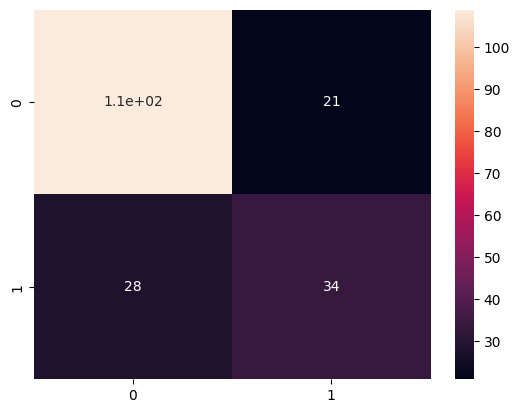

In [16]:
sn.heatmap(mapa_calor, annot=True)